# Question 1


(a)preprocessing

    Reads text8.txt and converts everything to lowercase.

In [ ]:
# Load the dataset
with open("text8.txt", "r") as file:
    text = file.read()

# Convert to lowercase
text = text.lower()

# Print first 500 characters to verify
print(text[:500])

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


    Removes everything except lowercase letters and spaces.    

In [ ]:
import re

# Keep only alphabetic characters and spaces
text = re.sub(r'[^a-z ]+', '', text)

# Print first 500 characters after cleaning
print(text[:500])

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


In [ ]:
# Tokenize the text (split into words)
tokens = text.split()

# Print the first 20 tokens
print(tokens[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


    Splits text into a list of words using spaces.

In [ ]:
import collections

# Count word frequencies
word_counts = collections.Counter(tokens)

# Find the 5 most frequent words
most_common_words = [word for word, _ in word_counts.most_common(20)]
print("Top 5 most frequent words:", most_common_words)


# Remove top 5 frequent words
filtered_tokens = [word for word in tokens if word not in most_common_words]
print(f"length before removing top 5 frequent words: {len(tokens)}")
print(f"length after removing top 5 frequent words: {len(filtered_tokens)}")
filtered_tokens=filtered_tokens[:2000000]

# Print first 20 filtered words
print(filtered_tokens[:20])


Top 5 most frequent words: ['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was', 'by', 'that']
length before removing top 5 frequent words: 17005207
length after removing top 5 frequent words: 11559122
['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst']


    Finds the top 5 most frequent words (often stopwords).
    Removes these words from the dataset.
    I'm only taking 2 million tokens of the data because the dataset was too large

In [ ]:
# Create vocabulary
vocab = list(set(filtered_tokens))

# Create word-to-index and index-to-word mappings
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Print vocabulary size
print("Vocabulary size:", len(vocab))

Vocabulary size: 95845


(b) Implementing the Skip-gram Model with Negative Sampling

    First, we create training pairs where:
	•	The center word is the target word.
	•	The context words are nearby words within a given window_size.
	•	Negative samples are randomly chosen words not in the context.

In [ ]:
import random

# Define window size (e.g., 2 means we take 2 words before and after)
window_size = 2

# Generate positive (center, context) pairs
positive_pairs = []

for i in range(window_size, len(filtered_tokens) - window_size):
    center_word = filtered_tokens[i]
    context_words = filtered_tokens[i - window_size:i] + filtered_tokens[i + 1:i + window_size + 1]

    for context_word in context_words:
        positive_pairs.append((word_to_index[center_word], word_to_index[context_word]))

# Print first 10 pairs
print("Example positive pairs:", positive_pairs[:10])

Example positive pairs: [(15992, 61808), (15992, 92203), (15992, 62306), (15992, 42828), (62306, 92203), (62306, 15992), (62306, 42828), (62306, 75178), (42828, 15992), (42828, 62306)]


	•	Slides a window across the text to collect context words.
	•	Each center word gets its context words within window_size.
	•	Converts words to indices using word_to_index.

In [ ]:
# Define number of negative samples per positive pair
num_negative_samples = 5

# Create a list of all word indices for sampling
word_indices = list(range(len(vocab)))

# Function to generate negative samples
def get_negative_samples(excluded_indices, num_samples):
    negatives = []
    while len(negatives) < num_samples:
        sample = random.choice(word_indices)
        if sample not in excluded_indices:
            negatives.append(sample)
    return negatives

# Generate (center, context, negative samples) tuples
training_data = []

for center, context in positive_pairs:
    negative_samples = get_negative_samples([center, context], num_negative_samples)
    training_data.append((center, context, negative_samples))

# Print first 5 training samples
print("Example training data (center, context, negatives):", training_data[:5])

Example training data (center, context, negatives): [(15992, 61808, [8640, 90585, 46122, 40605, 3710]), (15992, 92203, [47532, 40937, 49425, 45573, 69915]), (15992, 62306, [8577, 39648, 95330, 92637, 30809]), (15992, 42828, [64545, 53705, 59596, 51435, 20140]), (62306, 92203, [95060, 60920, 59850, 64043, 83690])]


	•	Samples num_negative_samples words that are not in the context.
	•	Uses random sampling while ensuring the negative words are different.
	•	Stores (center, context, negative samples) for training.

    We will now build the Skip-gram model with two embedding layers:
	1.	W_in (input embeddings) – maps words to vector representations.
	2.	W_out (output embeddings) – used for computing context similarity.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define model hyperparameters
embedding_dim = 100  # Dimensionality of word embeddings

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.W_in = nn.Embedding(vocab_size, embedding_dim)   # Input embedding (center word)
        self.W_out = nn.Embedding(vocab_size, embedding_dim)  # Output embedding (context word)

    def forward(self, center, context, negative_samples):
        # Look up embeddings
        v_c = self.W_in(center)  # Shape: (batch_size, embedding_dim)
        u_o = self.W_out(context)  # Shape: (batch_size, embedding_dim)
        u_k = self.W_out(negative_samples)  # Shape: (batch_size, num_neg_samples, embedding_dim)

        # Positive score (center word with actual context word)
        pos_score = torch.bmm(u_o.unsqueeze(1), v_c.unsqueeze(2)).squeeze()  # Dot product

        # Negative score (center word with negative samples)
        neg_score = torch.bmm(u_k, v_c.unsqueeze(2)).squeeze()

        return pos_score, neg_score

	•	W_in and W_out are trainable embeddings.
	•	forward() computes dot products between:
	•	v_c (center word) and u_o (true context words).
	•	v_c and u_k (negative sampled words).


In [ ]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super(NegativeSamplingLoss, self).__init__()

    def forward(self, pos_score, neg_score):
        pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-9).mean()  # Avoid log(0)
        neg_loss = -torch.log(1 - torch.sigmoid(neg_score) + 1e-9).mean()
        return pos_loss + neg_loss

# Define loss function and optimizer
loss_function = NegativeSamplingLoss()
model = SkipGramModel(len(vocab), embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

	•	Positive loss: Encourages center and context words to be closer.
	•	Negative loss: Pushes negative words away from the center word.
	•	Uses Adam optimizer to adjust W_in and W_out.


(c) Training the model

In [ ]:
# Define batch size and number of epochs
batch_size = 1024
num_epochs = 10

# Convert data to tensors
train_data = training_data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU if available
model.to(device)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    random.shuffle(train_data)  # Shuffle training data

    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]

        # Prepare batch data
        center_batch = torch.tensor([x[0] for x in batch], dtype=torch.long, device=device)
        context_batch = torch.tensor([x[1] for x in batch], dtype=torch.long, device=device)
        negative_batch = torch.tensor([x[2] for x in batch], dtype=torch.long, device=device)

        # Forward pass
        pos_score, neg_score = model(center_batch, context_batch, negative_batch)

        # Compute loss
        loss = loss_function(pos_score, neg_score)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Save embeddings
torch.save(model.W_in.weight.data, "word_embeddings.pth")
print("Embeddings saved successfully!")

Epoch 1, Loss: 15607.8960
Epoch 2, Loss: 5784.4798
Epoch 3, Loss: 4794.7844
Epoch 4, Loss: 4332.8797
Epoch 5, Loss: 4059.2370
Epoch 6, Loss: 3888.9041
Epoch 7, Loss: 3775.6439
Epoch 8, Loss: 3694.3749
Epoch 9, Loss: 3637.3370
Epoch 10, Loss: 3597.4218
Embeddings saved successfully!


In [ ]:
torch.save(model.W_in.weight.data, "word_embeddings_2.pth")

	•	Shuffles data to avoid order bias.
	•	Processes in mini-batches for efficiency.
	•	Performs forward pass → computes loss → backpropagation → updates weights.
	•	Trains on only 1 million samples to save time.
	•	Saves learned embeddings after training.


In [ ]:
import torch
import numpy as np

# Load saved embeddings
embeddings = torch.load("word_embeddings.pth").cpu().numpy()

# Print shape (should be: vocab_size × embedding_dim)
print("Embedding matrix shape:", embeddings.shape)

Embedding matrix shape: (95845, 100)


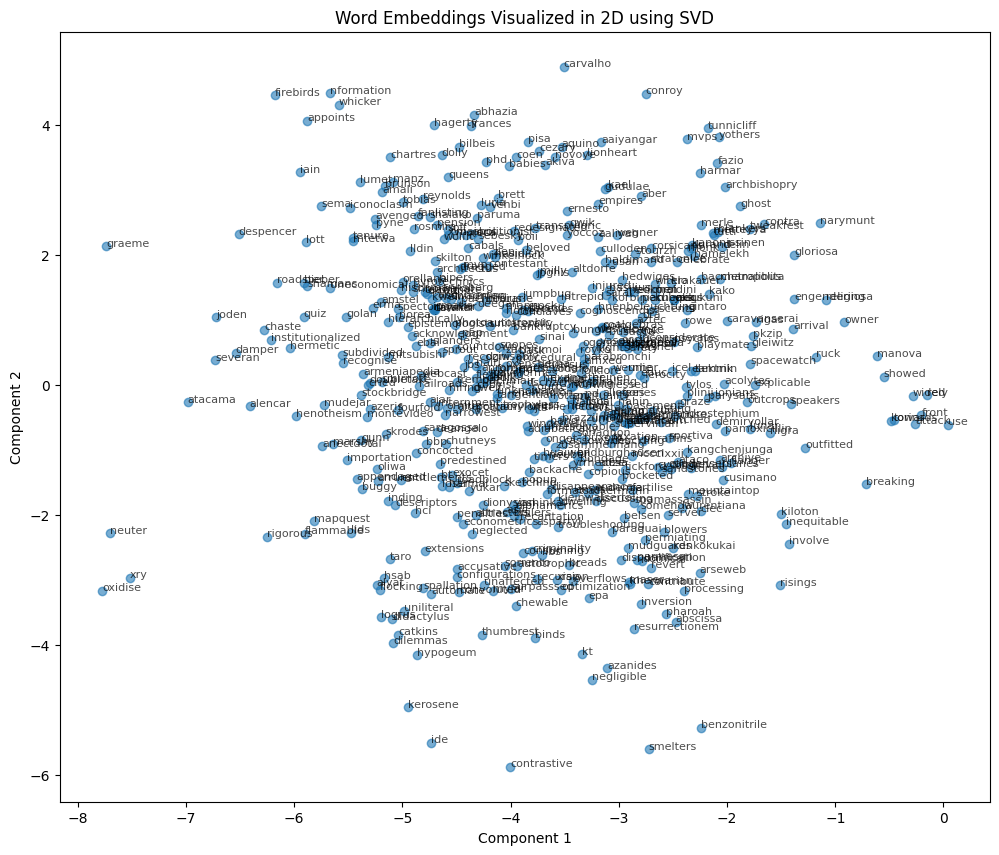

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Reduce embeddings to 2D
svd = TruncatedSVD(n_components=2)
embeddings_2D = svd.fit_transform(embeddings)

# Select 500 random words for visualization
random_indices = np.random.choice(len(vocab), 500, replace=False)
words_to_plot = [index_to_word[i] for i in random_indices]
embeddings_to_plot = embeddings_2D[random_indices]

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_to_plot[:, 0], embeddings_to_plot[:, 1], alpha=0.6)

# Annotate points with words
for i, word in enumerate(words_to_plot):
    plt.annotate(word, (embeddings_to_plot[i, 0], embeddings_to_plot[i, 1]), fontsize=8, alpha=0.7)

plt.title("Word Embeddings Visualized in 2D using SVD")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [ ]:
from scipy.spatial.distance import cosine

# Function to find most similar words
def find_most_similar(word, top_n=5):
    if word not in word_to_index:
        print(f"Word '{word}' not in vocabulary.")
        return

    word_vec = embeddings[word_to_index[word]]  # Get embedding of given word
    similarities = []

    for other_word, idx in word_to_index.items():
        if other_word != word:
            other_vec = embeddings[idx]
            similarity = 1 - cosine(word_vec, other_vec)  # Cosine similarity
            similarities.append((other_word, similarity))

    # Sort by highest similarity
    most_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]

    print(f"Top {top_n} words similar to '{word}':")
    for w, sim in most_similar:
        print(f"{w}: {sim:.4f}")

# Example test cases
find_most_similar("king")
find_most_similar("queen")
find_most_similar("apple")


Top 5 words similar to 'king':
niece: 0.4714
daughter: 0.4611
patriarchate: 0.4580
damascus: 0.4414
biagio: 0.4322
Top 5 words similar to 'queen':
consecrated: 0.4125
saumur: 0.4113
clotaire: 0.4081
gybi: 0.4041
disdainfully: 0.3979
Top 5 words similar to 'apple':
intel: 0.5392
amd: 0.5079
atari: 0.4470
paperspace: 0.4386
motorola: 0.4381


In [ ]:
find_most_similar("dog")

Top 5 words similar to 'dog':
mastering: 0.4371
popularised: 0.4315
cruger: 0.4240
countess: 0.4227
vereeniging: 0.4204


In [ ]:
def word_analogy(word1, word2, word3):
    if word1 not in word_to_index or word2 not in word_to_index or word3 not in word_to_index:
        print("One of the words is not in vocabulary.")
        return

    # Compute analogy vector: word1 - word2 + word3
    vec1 = embeddings[word_to_index[word1]]
    vec2 = embeddings[word_to_index[word2]]
    vec3 = embeddings[word_to_index[word3]]
    analogy_vec = vec1 - vec2 + vec3

    # Find closest word to analogy vector
    similarities = []

    for other_word, idx in word_to_index.items():
        if other_word not in [word1, word2, word3]:
            other_vec = embeddings[idx]
            similarity = 1 - cosine(analogy_vec, other_vec)
            similarities.append((other_word, similarity))

    best_match = max(similarities, key=lambda x: x[1])
    print(f"{word1} - {word2} + {word3} ≈ {best_match[0]} (Similarity: {best_match[1]:.4f})")

# Example test cases
word_analogy("king", "man", "woman")  # Expected: "queen"
word_analogy("paris", "france", "germany")  # Expected: "berlin"
word_analogy("walking", "walk", "run")  # Expected: "running"

king - man + woman ≈ bieber (Similarity: 0.4708)
paris - france + germany ≈ beeser (Similarity: 0.4419)
walking - walk + run ≈ aestheticians (Similarity: 0.3963)


(e) The impact of key hyperparameters

1 Embedding Dimension (embedding_dim)


	•	Small values (e.g., 50-100) → Limited representation power, good for small datasets.
	•	Larger values (e.g., 200-300) → Capture richer relationships, but require more data and computation.

2 Context Window Size (window_size)


	•	Small values (e.g., 2-3) → Captures syntactic relationships (e.g., “New” → “York”).
	•	Large values (e.g., 5-10) → Captures semantic relationships (e.g., “king” → “royal”).





3 Number of Negative Samples (num_neg_samples)


	•	Too few (e.g., 2-3) → Model doesn’t learn proper word contrasts.
	•	Too many (e.g., 20+) → Slows down training without much improvement.

4 Number of Training Epochs (num_epochs)


	•	Too few (e.g., 5-10) → Model underfits, embeddings are not meaningful.
	•	Too many (e.g., 50+) → Overfitting, embeddings memorize instead of generalizing.

    comparison of performance and computation time  of the 1 million and the 40 million samples with differnt hyperparameters
	•the hyperparametrs which are different for the 1 million are
    -batch size 512
    -no.0f epochs 5
    training time for 1 million is 0.5 hour and for 40 million is 8 hours


    results of 1 million
    Epoch 1, Loss: 8392.4049
    Epoch 2, Loss: 1501.8150
    Epoch 3, Loss: 856.4196
    Epoch 4, Loss: 633.5934
    Epoch 5, Loss: 499.9779\\
    Embeddings saved successfully!
    Top 5 words similar to 'king':
    nad: 0.4106
    daily: 0.4076
    revolutionaries: 0.3957
    shaw: 0.3886
    selling: 0.3877
    Top 5 words similar to 'queen':
    nationalrat: 0.4496
    telamon: 0.4263
    detail: 0.4022
    title: 0.4020
    complicated: 0.4009
    Top 5 words similar to 'apple':
    illyrians: 0.4239
    daba: 0.4224
    dot: 0.4101
    granulosa: 0.3937
    only: 0.3933
    king - man + woman ≈ cavitation (Similarity: 0.4299)
    paris - france + germany ≈ lutheran (Similarity: 0.4364)
    walking - walk + run ≈ thirds (Similarity: 0.4169)


# Question 2

loading the dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define transformations for preprocessing the dataset (Normalization and Conversion to Tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# Download and load the training and test dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Dataset loaded successfully!")

100%|██████████| 170M/170M [00:03<00:00, 48.0MB/s]


Dataset loaded successfully!


In [ ]:
# Function to unnormalize image tensors for visualization
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (reverse the normalization)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from tensor format
    plt.show()

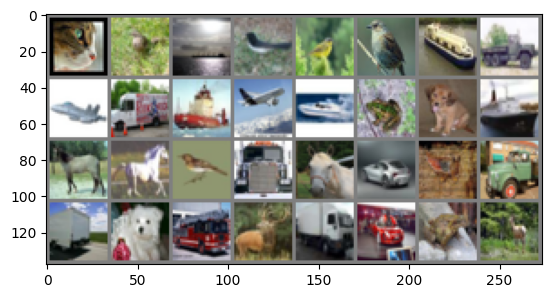

cat bird ship bird bird bird ship truck plane truck ship plane ship frog dog ship horse horse bird truck horse car bird truck truck dog truck deer truck car frog deer


In [ ]:
# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print corresponding labels
print(' '.join(classes[labels[j]] for j in range(32)))

a

(1)Defining Patch Embedding Layer

    •	Splitting the Image into Patches: The CIFAR-10 images (32×32) are divided into smaller non-overlapping patches of size 4×4.
    •	Using a Convolutional Layer for Patch Extraction: A Conv2D layer with a kernel size and stride of 4 is used to extract patches and transform them into a higher-dimensional embedding space.
    •	Flattening the Patches: The patches are flattened into 1D vectors so that they can be fed into the Transformer model.
    •	Changing the Tensor Shape: Since Transformers expect input in the format (batch_size, num_patches, embed_dim), we transpose the dimensions accordingly.
    •	Output Shape: If we use 4×4 patches, we get (batch_size, 64, 64), meaning 64 patches, each with a 64-dimensional embedding.

In [128]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Convolution layer to extract patches and project them into an embedding space
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        x: Input images of shape (batch_size, in_channels, img_size, img_size)
        Returns: Embedded patches of shape (batch_size, num_patches, embed_dim)
        """
        batch_size, _, _, _ = x.shape
        x = self.proj(x)  # (batch_size, embed_dim, num_patches_h, num_patches_w)
        x = x.flatten(2)  # Flatten spatial dimensions (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        return x

# Example usage
patch_embed = PatchEmbedding(img_size=32, patch_size=4, in_channels=3, embed_dim=64)
sample_input = torch.randn(1, 3, 32, 32)  # Simulating a single image
embedded_patches = patch_embed(sample_input)
print("Patch embeddings shape:", embedded_patches.shape)  # Expected: (1, num_patches, embed_dim)

Patch embeddings shape: torch.Size([1, 64, 64])


(2)Adding Positional Embeddings


    •	Why Positional Embeddings? Transformers are order-independent (unlike CNNs),
    so positional embeddings are used to inject spatial information into the model.
    •	Learnable Positional Embeddings: We define positional embeddings as a learnable tensor (nn.Parameter), which allows the model to learn the optimal position encodings during training.
    •	Adding the Positional Encoding: The embeddings are added to the patch embeddings before being passed into the Transformer encoder.
    •	Shape: The positional embedding tensor has the shape (1, num_patches, embed_dim) and is broadcasted across batches.
    •	Final Output: The output maintains the same shape but now contains both the content (patch embedding) and location (positional encoding).

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        # Learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        """
        x: Patch embeddings of shape (batch_size, num_patches, embed_dim)
        Returns: Positionally encoded embeddings of same shape
        """
        return x + self.pos_embed  # Add positional embeddings

# Example usage
num_patches = (32 // 4) ** 2  # 8x8 patches
embed_dim = 64

pos_embed = PositionalEmbedding(num_patches=num_patches, embed_dim=embed_dim)
positional_embeddings = pos_embed(embedded_patches)
print("Positional embeddings shape:", positional_embeddings.shape)  # Expected: (1, num_patches, embed_dim)

Positional embeddings shape: torch.Size([1, 64, 64])


(3)Implementing Multi-Head Self-Attention (MHA)

    •	Query (Q), Key (K), Value (V): Each input vector is transformed into three different vectors—Q, K, and V—which are used to compute attention scores.
    •	Multi-Head Splitting: The embedding is split into multiple heads, allowing the model to focus on different parts of the image simultaneously.
    •	Scaled Dot-Product Attention: Q and K are multiplied to compute attention scores, then scaled and passed through a softmax function.
    •	Weighted Sum with V: The attention weights are used to compute a weighted sum over V, capturing relevant information.
    •	Final Projection: The multi-head outputs are concatenated and passed through a linear layer to obtain the final output.

In [97]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.attention_weights = None  # Store attention maps for visualization

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        q = self.query(x).view(batch_size, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(batch_size, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(batch_size, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_probs = F.softmax(attn_scores, dim=-1)

        self.attention_weights = attn_probs  # Save attention weights

        attn_output = torch.matmul(attn_probs, v)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, num_tokens, embed_dim)
        return self.out_proj(attn_output)

mha = MultiHeadSelfAttention(embed_dim=64, num_heads=4)
attention_output = mha(positional_embeddings)
print("MHA output shape:", attention_output.shape)  # Expected: (1, num_patches, embed_dim)

MHA output shape: torch.Size([1, 64, 64])


• Data Augmentation: Applies random horizontal flips and cropping to increase dataset diversity.
• Normalization: Rescales pixel values to [-1,1] to stabilize training.
• DataLoader: Creates mini-batches for efficient training with a batch size of 128.
• Shuffling: Randomly shuffles the training data to improve generalization.
• Dataset Size: Prints the number of training and test images.

In [102]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations: Normalize and apply data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data Augmentation (flip images randomly)
    transforms.RandomCrop(32, padding=4),  # Crop with padding
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test sets
batch_size = 128  # Define batch size
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print dataset information
print(f"Train dataset size: {len(trainset)}, Test dataset size: {len(testset)}")

Train dataset size: 50000, Test dataset size: 10000


• Layer Normalization before self-attention improves training stability.
• Residual Connections (adding input to output) help in gradient flow.
• MLP Layer (Feedforward network) further refines features after attention.
• Dropout prevents overfitting by randomly disabling neurons during training.

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # MLP Block (2-layer feedforward network)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),  # Activation function
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        x: Input embeddings (batch_size, num_patches, embed_dim)
        Returns: Processed embeddings of the same shape
        """
        # Self-attention + residual connection
        x = x + self.attn(self.norm1(x))
        # MLP + residual connection
        x = x + self.mlp(self.norm2(x))
        return x

Patch Embedding & Positional Encoding: Converts images into a sequence of tokens.
• CLS Token: A learnable token that captures global image features.
• Transformer Encoder: Consists of multiple self-attention + MLP layers.
• Final Classification Head: Uses a fully connected layer to classify images.
• Layer Normalization before classification ensures stable activations.

In [112]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=64, num_heads=8, num_layers=6, mlp_dim=128, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.dropout = nn.Dropout(0.1)

        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.attention_maps = []  # Store attention maps for all layers

    def forward(self, x):
        self.attention_maps = []  # Clear previous attention maps
        x = self.patch_embed(x)
        batch_size = x.shape[0]
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        for layer in self.transformer_layers:
            x = layer(x)
            self.attention_maps.append(layer.attn.attention_weights.detach().cpu())  # Store attention maps

        x = self.norm(x[:, 0])  # CLS token
        return self.head(x)
# Instantiate model
vit = VisionTransformer().to(device) # Move the model to the correct device

	Use CrossEntropy Loss (standard for classification).
	•	Use Adam Optimizer with weight decay.
	•	Train for 20 epochs and monitor accuracy.

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=0.001, weight_decay=0.01)

num_epochs = 20

for epoch in range(num_epochs):
    vit.train()
    total_loss = 0
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")

Epoch [1/20], Loss: 738.7150, Accuracy: 0.3058
Epoch [2/20], Loss: 630.2148, Accuracy: 0.4165
Epoch [3/20], Loss: 581.3855, Accuracy: 0.4611
Epoch [4/20], Loss: 548.7247, Accuracy: 0.4929
Epoch [5/20], Loss: 524.3421, Accuracy: 0.5168
Epoch [6/20], Loss: 503.2311, Accuracy: 0.5340
Epoch [7/20], Loss: 489.5198, Accuracy: 0.5481
Epoch [8/20], Loss: 472.3086, Accuracy: 0.5650
Epoch [9/20], Loss: 460.2063, Accuracy: 0.5779
Epoch [10/20], Loss: 447.1181, Accuracy: 0.5880
Epoch [11/20], Loss: 433.8567, Accuracy: 0.5997
Epoch [12/20], Loss: 422.7488, Accuracy: 0.6133
Epoch [13/20], Loss: 411.3843, Accuracy: 0.6242
Epoch [14/20], Loss: 404.5438, Accuracy: 0.6328
Epoch [15/20], Loss: 390.0069, Accuracy: 0.6445
Epoch [16/20], Loss: 380.8002, Accuracy: 0.6528
Epoch [17/20], Loss: 370.0371, Accuracy: 0.6636
Epoch [18/20], Loss: 359.8537, Accuracy: 0.6728
Epoch [19/20], Loss: 352.3015, Accuracy: 0.6775
Epoch [20/20], Loss: 344.9656, Accuracy: 0.6854


In [ ]:
def evaluate(model, dataloader, device):
    """
    Evaluates the model on the test dataset.

    Args:
    - model: Trained ViT model.
    - dataloader: Test DataLoader.
    - device: "cuda" or "cpu".

    Returns:
    - test_accuracy: Model accuracy on the test dataset.
    """
    model.eval()  # Set to evaluation mode
    correct, total = 0, 0

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    return test_accuracy

# Run evaluation
test_acc = evaluate(vit, testloader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6752


In [ ]:
from sklearn.metrics import classification_report
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def evaluate_metrics(model, dataloader, device):
    """
    Computes precision, recall, and F1-score for each class.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

# Run evaluation
evaluate_metrics(vit, testloader, device)

              precision    recall  f1-score   support

       plane       0.67      0.77      0.71      1000
         car       0.86      0.66      0.75      1000
        bird       0.70      0.45      0.55      1000
         cat       0.47      0.58      0.52      1000
        deer       0.64      0.61      0.62      1000
         dog       0.60      0.57      0.58      1000
        frog       0.71      0.76      0.73      1000
       horse       0.72      0.74      0.73      1000
        ship       0.78      0.82      0.80      1000
       truck       0.70      0.79      0.74      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.68      0.68      0.67     10000



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class labels
class_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Mean and Std used for normalization in CIFAR-10
cifar10_mean = np.array([0.4914, 0.4822, 0.4465])  # Mean for each channel (R, G, B)
cifar10_std = np.array([0.2470, 0.2435, 0.2616])   # Std for each channel (R, G, B)

def denormalize(image):
    """
    Converts a normalized image back to original pixel range [0,1] for display.
    """
    image = image * cifar10_std.reshape(1, 1, 3) + cifar10_mean.reshape(1, 1, 3)  # Undo normalization
    image = np.clip(image, 0, 1)  # Ensure values are in [0,1] range
    return image

def show_predictions(model, dataloader, device, num_images=5):
    """
    Displays images from the test set along with their true labels and model predictions.
    """
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch of test images
    images, labels = images[:num_images], labels[:num_images]  # Select a few images

    # Move images to device
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        predicted_labels = torch.argmax(outputs, dim=1)  # Get class predictions

    # Convert images to numpy format
    images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Convert from (C, H, W) to (H, W, C)

    # Plot the images with their labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        img = denormalize(images[i])  # Denormalize image
        ax.imshow(img)  # Display image
        true_label = class_labels[labels[i].item()]  # Get true label
        pred_label = class_labels[predicted_labels[i].item()]  # Get predicted label
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        ax.axis("off")  # Hide axes
    plt.show()

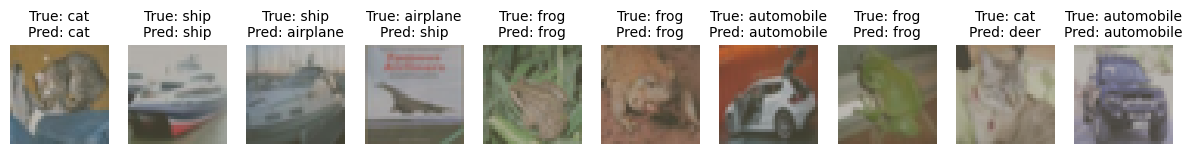

In [ ]:
show_predictions(vit, testloader, device, num_images=10)

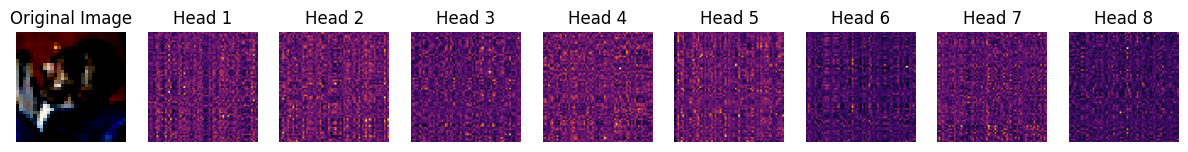

In [ ]:
import matplotlib.pyplot as plt

def plot_attention_maps(image, attn_maps, num_heads=8):
    """
    Plots attention maps from different heads for a given image.
    """
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(15, 5))

    axes[0].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i in range(num_heads):
        axes[i + 1].imshow(attn_maps[0, i].numpy(), cmap="inferno")
        axes[i + 1].set_title(f"Head {i+1}")
        axes[i + 1].axis("off")

    plt.show()

# Run visualization
image, attn_maps = get_attention_maps(vit, testloader, device, layer_idx=0)
plot_attention_maps(image, attn_maps)